<a href="https://colab.research.google.com/github/riyag283/Deep-Learning-Course-Autumn20/blob/master/imgCNN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri Nov 20 15:33:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torchvision

In [ ]:
n_epochs = 1000
batch_size_train = 1024
batch_size_test = 1024
learning_rate = 0.001
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
example_data.shape

torch.Size([1024, 1, 28, 28])

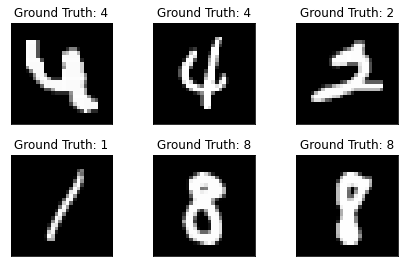

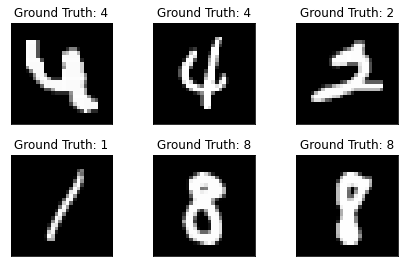

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      train_losses.append(loss.item())
      train_counter.append(epoch)
      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')
  print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
  g_2 = []
  for name, param in network.named_parameters():
      if param.requires_grad and "bias" not in name:
          #print (name, param.grad.data)
          g_2.append(torch.flatten(param.grad.data))
  #print(torch.norm(torch.cat([g_2[0],g_2[1],g_2[2],g_2[3]],dim=0)))
  return torch.norm(torch.cat([g_2[0],g_2[1],g_2[2],g_2[3]],dim=0)).item()

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
test()
gradients = []
for epoch in range(1, n_epochs + 1):
  grads = train(epoch)
  gradients.append(grads)
test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3089, Accuracy: 674/10000 (7%)

Train Epoch: 1 [35264/60000 (98%)]	Loss: 2.302721
Train Epoch: 2 [35264/60000 (98%)]	Loss: 2.292674
Train Epoch: 3 [35264/60000 (98%)]	Loss: 2.285597
Train Epoch: 4 [35264/60000 (98%)]	Loss: 2.278233
Train Epoch: 5 [35264/60000 (98%)]	Loss: 2.269239
Train Epoch: 6 [35264/60000 (98%)]	Loss: 2.275110
Train Epoch: 7 [35264/60000 (98%)]	Loss: 2.262068
Train Epoch: 8 [35264/60000 (98%)]	Loss: 2.245333
Train Epoch: 9 [35264/60000 (98%)]	Loss: 2.237262
Train Epoch: 10 [35264/60000 (98%)]	Loss: 2.210427
Train Epoch: 11 [35264/60000 (98%)]	Loss: 2.220911
Train Epoch: 12 [35264/60000 (98%)]	Loss: 2.177619
Train Epoch: 13 [35264/60000 (98%)]	Loss: 2.149305
Train Epoch: 14 [35264/60000 (98%)]	Loss: 2.119451
Train Epoch: 15 [35264/60000 (98%)]	Loss: 2.048548
Train Epoch: 16 [35264/60000 (98%)]	Loss: 2.047849
Train Epoch: 17 [35264/60000 (98%)]	Loss: 1.978734
Train Epoch: 18 [35264/60000 (98%)]	Loss: 1.861277
Train Epoch: 19 [35264/60000 (98%)]

In [ ]:
print('Done')

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
#plt.scatter(test_counter, test_losses, color='red')
#plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of pass')
plt.ylabel('negative log likelihood loss')

In [ ]:
x = np.arange(len(gradients))
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Gradient Norm vs Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Gradient Norm', fontsize=18)
plt.scatter(x,gradients)
plt.plot(x,gradients)